# Recommender System

Blah blah blah

## Import Libraries and Define File Paths

In [137]:
import scipy
import random
import pandas as pd
import numpy as np
import threadpoolctl
from collections import defaultdict
from implicit.als import AlternatingLeastSquares as ALS
from scipy.spatial import distance
from surprise import Dataset, Reader
from surprise.model_selection import cross_validate, train_test_split, KFold
from surprise.prediction_algorithms.knns import KNNBasic, KNNWithMeans
from surprise.prediction_algorithms.matrix_factorization import SVD
from implicit.evaluation import (AUC_at_k,
                                 mean_average_precision_at_k,
                                 ndcg_at_k, precision_at_k)
from implicit.evaluation import train_test_split
import matplotlib.pyplot as plt

dir = "../dataset/utility"

def load_dataset():
    items_df = pd.read_csv(f"{dir}/itemset_preprocessed.csv")
    items_df.set_index("ASIN", inplace=True)
    items_df.drop('customerReview', inplace=True, axis=1)
    items_df = pd.get_dummies(items_df, columns=['brand'], dtype='float')
    items_df.fillna(0, inplace=True)
 
    df_utility = pd.read_csv(f"{dir}/utility_topn.csv")
    df_utility.set_index("reviewerID", inplace=True)

    reviews_df = pd.read_csv(f"{dir}/reviews.csv")
    reviews_df = reviews_df.replace(np.nan, '', regex=True)
    reviews_df.set_index('reviewerID', inplace=True)
    
    asins_df = pd.read_csv(f"{dir}/asin_product_mapping.csv")

    print(f"shape of df_utility: {df_utility.shape}")
    print(f"shape of items_df: {items_df.shape}")
    print(f"shape of asins_df: {asins_df.shape}")
    return items_df, df_utility, reviews_df, asins_df

## Load Dataset

In [138]:
items_df, df_utility, reviews_df, asins_df = load_dataset()

shape of df_utility: (445, 33510)
shape of items_df: (33554, 16340)
shape of asins_df: (36059, 2)


# Try all algorithms
* Neighborhood-based collaborative filtering
* Latent-factor based collaborative filtering
* Content-based collaborative filtering

## Neighborhood-based Collaborative Filtering

From Surprise

In [140]:
melted_user_df = df_utility.copy().reset_index().melt(
    'reviewerID', var_name='ASIN', value_name='rating').dropna()
reader = Reader(rating_scale=(0,5))
dataset = Dataset.load_from_df(melted_user_df, reader)
algos = [KNNBasic(), KNNWithMeans(), SVD()]

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


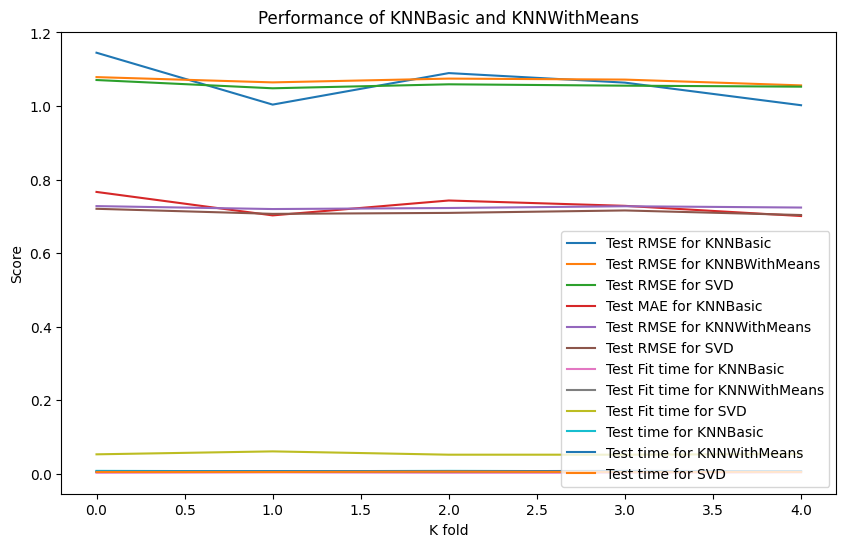

In [141]:
metrics_list = []
for algo in algos:
    metrics = cross_validate(algo, dataset)
    metrics['mean_test_rmse'] = np.mean(metrics['test_rmse'])
    metrics['mean_test_mae'] = np.mean(metrics['test_mae'])
    metrics_list.append(metrics)


k = range(0,5)
plt.figure(figsize=(10, 6))
plt.plot(k, metrics_list[0]['test_rmse'], label='Test RMSE for KNNBasic')
plt.plot(k, metrics_list[1]['test_rmse'], label='Test RMSE for KNNBWithMeans')
plt.plot(k, metrics_list[2]['test_rmse'], label='Test RMSE for SVD')
plt.plot(k, metrics_list[0]['test_mae'], label='Test MAE for KNNBasic')
plt.plot(k, metrics_list[1]['test_mae'], label='Test RMSE for KNNWithMeans')
plt.plot(k, metrics_list[2]['test_mae'], label='Test RMSE for SVD')
plt.plot(k, metrics_list[0]['fit_time'], label='Test Fit time for KNNBasic')
plt.plot(k, metrics_list[1]['fit_time'], label='Test Fit time for KNNWithMeans')
plt.plot(k, metrics_list[2]['fit_time'], label='Test Fit time for SVD')
plt.plot(k, metrics_list[0]['test_time'], label='Test time for KNNBasic')
plt.plot(k, metrics_list[1]['test_time'], label='Test time for KNNWithMeans')
plt.plot(k, metrics_list[2]['test_time'], label='Test time for SVD')
plt.xlabel("K fold")
plt.ylabel("Score")
plt.legend(loc='lower right')
plt.title("Performance of KNNBasic and KNNWithMeans")
plt.show()

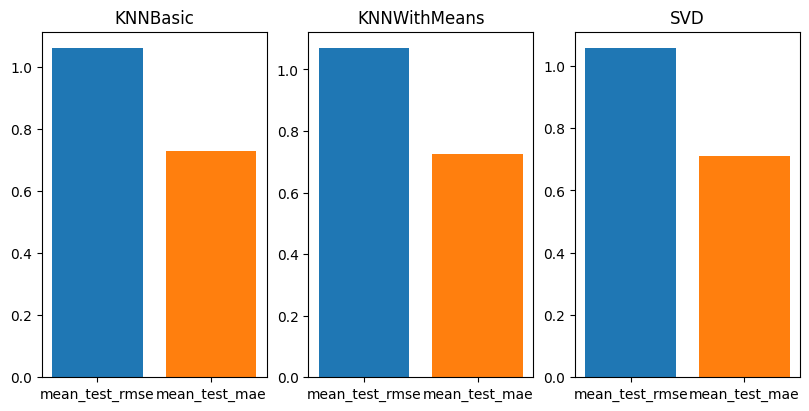

In [142]:
fig, axes = plt.subplots(1, 3, figsize=(8,4), layout='constrained')
method = ["KNNBasic", "KNNWithMeans", "SVD"]
ind = 0
for m in metrics_list:
    for k in m:
        if 'mean' in k:
            axes[ind].bar(k, m[k])
            axes[ind].set_title(method[ind])
    ind += 1
plt.show()

### Precision and Recall

Taken from https://github.com/NicolasHug/Surprise/blob/master/examples/precision_recall_at_k.py

In [143]:
def precision_recall_at_k(predictions, k=10, threshold=3.5):
    """Return precision and recall at k metrics for each user"""
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():
        user_ratings.sort(key=lambda x: x[0], reverse=True)
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])
        n_rel_and_rec_k = sum(
            ((true_r >= threshold) and (est >= threshold))
            for (est, true_r) in user_ratings[:k]
        )
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0
    return precisions, recalls
kf = KFold(n_splits=5)

algo_res = []
for algo in algos:
    print(f"computing precision and recall for {algo}")
    res_dict = {'precision': [], 'recall': []}
    for trainset, testset in kf.split(dataset):
        algo.fit(trainset)
        predictions = algo.test(testset)
        precisions, recalls = precision_recall_at_k(predictions, k=5, threshold=4)
        res_dict['precision'].append(sum(prec for prec in precisions.values()) / len(precisions))
        res_dict['recall'].append(sum(rec for rec in recalls.values()) / len(recalls))
    algo_res.append(res_dict)

computing precision and recall for <surprise.prediction_algorithms.knns.KNNBasic object at 0x000002146E64DF90>
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
computing precision and recall for <surprise.prediction_algorithms.knns.KNNWithMeans object at 0x00000214A577CD90>
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
computing precision and recall for <surprise

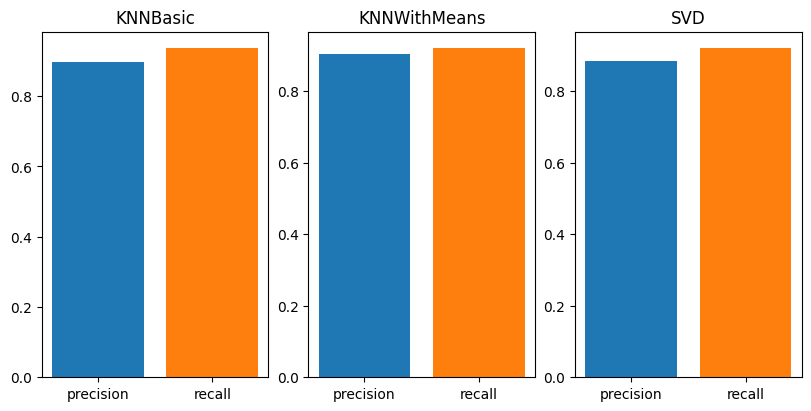

In [144]:
fig, axes = plt.subplots(1, 3, figsize=(8,4), layout='constrained')
method = ["KNNBasic", "KNNWithMeans", "SVD"]
ind = 0
for m in algo_res:
    for k in m:
        axes[ind].bar(k, m[k])
        axes[ind].set_title(method[ind])
    ind += 1
plt.show()

### Get TopN Recommendations for a user

Taken from https://github.com/NicolasHug/Surprise/blob/master/examples/top_n_recommendations.py

In [145]:
def get_top_n(predictions, n=10):
    """Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n
testset = trainset.build_anti_testset()
predictions = algos[2].test(testset) # SVD
top_n = get_top_n(predictions, n=10)
recommendations = {}
for uid, user_ratings in top_n.items():
    recommendations[uid] = [iid for (iid, _) in user_ratings]

In [ ]:
# map back numerical recommendations to their reviewerID

### Pick out users and explore their history and recommendations

Use SVD because KNN sucks

In [146]:
asins_df.set_index('ASIN', inplace=True)

In [147]:
def show_user_history_and_recos(recommendations, user_id):
    """
    Display user purchase history and recommendations
    """
    display(reviews_df.loc[[user_id]][['ProductName', 'reviewRating']])
    reco_list = recommendations[user_id]
    print("recommended items")
    display(asins_df.loc[reco_list])
    print('\n')

In [152]:
userids = [x for x in list(recommendations.keys()) if len(x.split('_')[-1]) > 1][:5]
for user_id in userids:
    show_user_history_and_recos(recommendations, user_id)

,ProductName,reviewRating
reviewerID,,
John_AG6PIPVFXVM2UIU2LKEGND4SN6GQ,romitaz_iphone_fast_charger_lightning_cable_[a...,5.0
John_AG6PIPVFXVM2UIU2LKEGND4SN6GQ,wantdo_men's_wool_blend_jacket_stand_collar_wi...,3.0
John_AG6PIPVFXVM2UIU2LKEGND4SN6GQ,cooler_master_masterliquid_ml240l_v2_rgb_cpu_l...,5.0
John_AG6PIPVFXVM2UIU2LKEGND4SN6GQ,no_918_erica_crushed_sheer_voile_rod_pocket_cu...,5.0
John_AG6PIPVFXVM2UIU2LKEGND4SN6GQ,no_918_emily_sheer_voile_rod_pocket_curtain_pa...,5.0
John_AG6PIPVFXVM2UIU2LKEGND4SN6GQ,sun_zero_barrow_energy_efficient_rod_pocket_cu...,4.0
John_AG6PIPVFXVM2UIU2LKEGND4SN6GQ,dash_cam_front_and_rear_chortau_dual_dash_cam_...,5.0
John_AG6PIPVFXVM2UIU2LKEGND4SN6GQ,tide_hygienic_clean_heavy_duty_10x_free_power_...,5.0
John_AG6PIPVFXVM2UIU2LKEGND4SN6GQ,biore_deep_pore_charcoal_face_wash_facial_clea...,5.0


recommended items


,name
ASIN,
b0c5nq9wt9,Women's Legendary High Rise Trouser Jean
b086mms6fv,Intel Core i7-10700KF Desktop Processor 8 Core...
b07gzpynwq,YESNO Women Sweater Graphic Oversized Pullover...
b08sg2lkwg,Physicians Formula Mini Murumuru Butter Bronze...
b0144wk25c,"rockpapa Comfort Kids Headphones for School, L..."
b0cthtvtfg,Ariat Male Rebar M5 Straight DuraStretch Basic...
b0cs3jr3vh,Gunsmoke in Silver City: A Historical Western ...
b0csb3lrkw,Observer: A Novel
b074t6c4ys,"MICHELANGELO Knife Set, Sharp 10-Piece Kitchen..."


,ProductName,reviewRating
reviewerID,,
Nancy Badillo_AF3B5PXRIGWOWRGPB7XIKWNEJNYA,ninja_dz201_foodi_8_quart_6in1_dualzone_2baske...,5.0
Nancy Badillo_AF3B5PXRIGWOWRGPB7XIKWNEJNYA,dude_wipes__flushable_wipes__unscented_8_pack_...,5.0
Nancy Badillo_AF3B5PXRIGWOWRGPB7XIKWNEJNYA,regalo_swing_down_crib_rail_with_reinforced_an...,5.0
Nancy Badillo_AF3B5PXRIGWOWRGPB7XIKWNEJNYA,hiccapop_convertible_crib_bed_rail_for_toddler...,5.0
Nancy Badillo_AF3B5PXRIGWOWRGPB7XIKWNEJNYA,dove_men+care_antiperspirant_deodorant_stick_c...,5.0
Nancy Badillo_AF3B5PXRIGWOWRGPB7XIKWNEJNYA,tide_pods_laundry_detergent_soap_pods_spring_m...,5.0
Nancy Badillo_AF3B5PXRIGWOWRGPB7XIKWNEJNYA,essence_|_lash_princess_false_lash_effect_masc...,5.0
Nancy Badillo_AF3B5PXRIGWOWRGPB7XIKWNEJNYA,nyx_professional_makeup_micro_brow_pencil_eyeb...,5.0
Nancy Badillo_AF3B5PXRIGWOWRGPB7XIKWNEJNYA,movo_vxr10_universal_shotgun_mic_for_camera__c...,5.0


recommended items


,name
ASIN,
b085sv35mt,Panasonic 4-in-1 1000W Microwave Oven with Air...
b0chxwxnhl,Tajsoon 9 Tier Tree Bookshelf with Drawer Book...
b01dai6jus,Seagate Enterprise Capacity | ST10000NM0016 | ...
b0cs3jr3vh,Gunsmoke in Silver City: A Historical Western ...
b0cl9kdmyd,Springrain Men's Wool Blend Pea Coat Notched C...
b0cvdrmb1c,A Duke’s Touch: A Historical Regency Romance N...
b09g9yj1q9,Lazada Stuffed Cat Dolls Animal Kitty Plush To...
b0997fbqfj,The Paris Apartment: A Novel
b0bzhsk29b,TERRAMASTER D6-320 External Hard Drive Enclosu...


,ProductName,reviewRating
reviewerID,,
Corey Smith_AEPBOORKRFPG6LBDP756XA7O37XQ,comfort_spaces_grey_queen_comforter_set__3_pie...,5.0
Corey Smith_AEPBOORKRFPG6LBDP756XA7O37XQ,tajsoon_9_tier_tree_bookshelf_with_drawer_book...,5.0
Corey Smith_AEPBOORKRFPG6LBDP756XA7O37XQ,freexployer_small_bookshelf_3_tier_vintage_ind...,5.0
Corey Smith_AEPBOORKRFPG6LBDP756XA7O37XQ,lennyvillna_dresser_for_bedroom_tall_dresser_w...,5.0
Corey Smith_AEPBOORKRFPG6LBDP756XA7O37XQ,boonatu_dresser_for_bedroom_with_6_drawers_whi...,5.0
Corey Smith_AEPBOORKRFPG6LBDP756XA7O37XQ,bedroom_nightstands_wooden_night_stands_with_r...,5.0
Corey Smith_AEPBOORKRFPG6LBDP756XA7O37XQ,fixwal_nightstands_set_of_2_with_charging_stat...,5.0
Corey Smith_AEPBOORKRFPG6LBDP756XA7O37XQ,aobafuir_rattan_nightstand_2_drawer_dresser_fo...,5.0
Corey Smith_AEPBOORKRFPG6LBDP756XA7O37XQ,mr_ironstone_nightstand_with_charging_station_...,5.0


recommended items


,name
ASIN,
b000q5zgia,"BIC Brite Liner Highlighters, Chisel Tip, 5-Co..."
b00iic63p8,"Metra Electronics 82-8148 6"" to 6-3/4"" Speaker..."
b07wvx3hbr,"WOMACO Printed Office Chair Covers, Stretch Co..."
b0crvhcfgj,"2FT USB C Charger Cable 3A, 3Pack USB A to Typ..."
b00i5n1jj0,"ATTITUDE Baby Wipes Refills, 100% Biodegrable ..."
b00pbx3l7k,COSRX Snail Mucin 96% Power Repairing Essence ...
b0b9twy11q,WYZE Cam Pan v3 Indoor/Outdoor IP65-Rated 1080...
b0bfx4bsxf,Skechers Women's Parties-Mate Oxford Shoes
b073wmg59j,"wet n wild MegaGlo Highlighting Powder, Highli..."


,ProductName,reviewRating
reviewerID,,
Steven_AHPRRIDI7LA42GJZ7OKWELQPNOIQ,gerber_snacks_for_baby_lil_crunchies_mild_ched...,5.0
Steven_AHPRRIDI7LA42GJZ7OKWELQPNOIQ,energizer_max_c_batteries_premium_alkaline_c_c...,5.0
Steven_AHPRRIDI7LA42GJZ7OKWELQPNOIQ,ocedar_powercorner_one_sweep_broom_with_stepon...,5.0
Steven_AHPRRIDI7LA42GJZ7OKWELQPNOIQ,ocedar_pet_pro_broom_stepon_dustpan_powercorne...,5.0
Steven_AHPRRIDI7LA42GJZ7OKWELQPNOIQ,"oxo_good_grips_pro_10""_frying_pan_skillet_3lay...",5.0
Steven_AHPRRIDI7LA42GJZ7OKWELQPNOIQ,corsair_rm1000x_2021_fully_modular_atx_power_s...,5.0
Steven_AHPRRIDI7LA42GJZ7OKWELQPNOIQ,seagate_barracuda_8tb_internal_hard_drive_hdd_...,5.0
Steven_AHPRRIDI7LA42GJZ7OKWELQPNOIQ,intel_core_i513600k_desktop_processor_14_6_pco...,5.0
Steven_AHPRRIDI7LA42GJZ7OKWELQPNOIQ,libman_2011_nitty_gritty_roller_mop_refill,5.0


recommended items


,name
ASIN,
b015zzwm1y,Calphalon Nonstick Frying Pan with Stay-Cool H...
b08xrg41x6,Amazon Essentials Women's Long-Sleeve Crewneck...
b09zxxbt3g,GRAPMKTG Home Decor Pulp Reading Women Thinker...
b011f7w3lu,"Thermal Grizzly Kryonaut, High Performance The..."
b08z1scrrq,Cinch Mop - Microfiber Mop for Hardwood Floors...
b0cnh9t9ll,Hoowel Smart Watch for Men and Women - Alexa B...
b011dg5b4e,Logitech M510 Wireless Mouse-Black (Renewed)
b0br3nxtkk,"Tribesigns Modern Computer Desk, 63 x 31.5 inc..."
b004tnm3iq,Kenneth Cole REACTION Out of Bounds Lightweigh...


,ProductName,reviewRating
reviewerID,,
Penny Lane_AGH62UUHMMOSEJPZP3DBQN67WW5A,baby_wipes_unscented_by_boogie_wipes_wet_wipes...,5.0
Penny Lane_AGH62UUHMMOSEJPZP3DBQN67WW5A,2_pack_aux_cableauxiliary_cable16ft/05m_hifi_s...,5.0
Penny Lane_AGH62UUHMMOSEJPZP3DBQN67WW5A,bubble_bum_inflatable_travel_portable_booster_...,5.0
Penny Lane_AGH62UUHMMOSEJPZP3DBQN67WW5A,amazon_essentials_women's_lightweight_waterres...,5.0
Penny Lane_AGH62UUHMMOSEJPZP3DBQN67WW5A,scotchbrite_dishwand_brush_scrubber_for_cleani...,5.0
Penny Lane_AGH62UUHMMOSEJPZP3DBQN67WW5A,cosrx_snail_mucin_96%_power_repairing_essence_...,5.0
Penny Lane_AGH62UUHMMOSEJPZP3DBQN67WW5A,mario_badescu_setting_facial_spray_mist_with_a...,5.0
Penny Lane_AGH62UUHMMOSEJPZP3DBQN67WW5A,eywamage_grey_glass_flameless_candles_with_rem...,5.0
Penny Lane_AGH62UUHMMOSEJPZP3DBQN67WW5A,serwalin_pampas_grass_decor_white_177_inch_6pc...,5.0


recommended items


,name
ASIN,
b0ccpxzjbp,Hydro Flask Trail Series Lightweight Water Bot...
b011f7w3lu,"Thermal Grizzly Kryonaut, High Performance The..."
b0ct3t4qzf,Her Mysterious Duke: A Historical Regency Roma...
b09y65tf7f,"SAFEE MRROR Shatterproof Wall Mirror Tiles,Mad..."
b01m1np02k,Dove Men+Care Antiperspirant Deodorant Stick C...
b0cv4fjf3b,Her Wicked Duke: A Historical Regency Romance ...
1501171356,The Last Thing He Told Me: A Novel
b0bpgx9rr6,UniqueMe for Samsung Galaxy S23 Screen Protect...
b00712o2d6,Hape Pound & Tap Bench with Slide Out Xylophon...


## Latent-factor based Collaborative Filtering

### ALS

shape of df_utility: (445, 33510)
shape of items_df: (33554, 16340)
shape of asins_df: (36059, 2)


'export' is not recognized as an internal or external command,
operable program or batch file.
100%|██████████| 394/394 [00:00<00:00, 5115.65it/s]


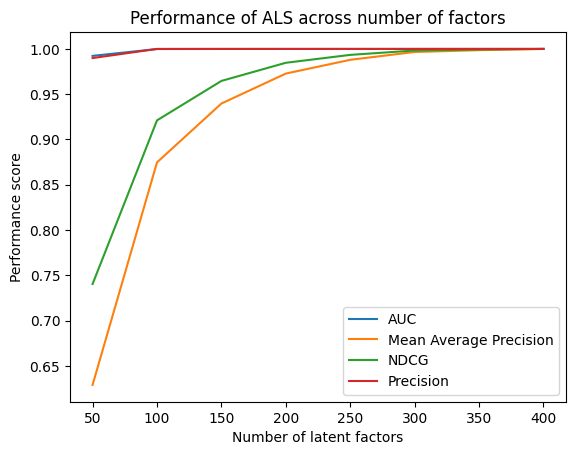

In [167]:
items_df, df_utility, reviews_df, items_with_info_df = load_dataset()
csr_utility = scipy.sparse.csr_matrix(df_utility.fillna(0).values)
!export OPENBLAS_NUM_THREADS=1
threadpoolctl.threadpool_limits(1, "blas")

auc_list = []
mean_ave_precision_list = []
ndcg_list = []
precision_list = []

factors = [50, 100, 150, 200, 250, 300,
           350, 400]

for factor in factors:
    model = ALS(
        factors=factor,
        regularization=0.1,
        alpha=1,
        calculate_training_loss=True,
        use_cg=True,
        iterations=30,
        random_state=143
    )
    model.fit(csr_utility)

    # evaluation
    training_set, test_set = train_test_split(
        csr_utility,
        train_percentage=0.85,
        random_state=143
    )
    auc = AUC_at_k(model,training_set,test_set,
                K=len(df_utility), show_progress=True)
    mean_ave_precision = mean_average_precision_at_k(model, training_set,
                test_set, K=len(df_utility), show_progress=True)
    ndcg = ndcg_at_k(model, training_set, test_set,
                K=len(df_utility), show_progress=True)
    precision = precision_at_k(model, training_set,
                test_set, K=len(df_utility), show_progress=True)
    auc_list.append(auc)
    mean_ave_precision_list.append(mean_ave_precision)
    ndcg_list.append(ndcg)
    precision_list.append(precision)

plt.plot(factors, auc_list, label='AUC')
plt.plot(factors, mean_ave_precision_list, label='Mean Average Precision')
plt.plot(factors, ndcg_list, label='NDCG')
plt.plot(factors, precision_list, label='Precision')
plt.xlabel('Number of latent factors')
plt.ylabel('Performance score')
plt.title("Performance of ALS across number of factors")
plt.legend()
plt.show()

In [168]:
model = ALS(
    factors=300,
    regularization=0.1,
    alpha=1,
    calculate_training_loss=True,
    use_cg=True,
    iterations=30,
    random_state=143
)
model.fit(csr_utility)

  0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 30/30 [00:03<00:00,  7.93it/s, loss=0.000172]


In [169]:
def get_ilocs(df_utility, userids):
    userids_ilocs = []
    original_indices = df_utility.index
    for u in userids:
        #display(df_utility.loc[u])
        userids_ilocs.append(original_indices.get_loc(u))
        #display(df_utility.iloc[original_indices.get_loc(u), :])
    return userids_ilocs
userids_ilocs = get_ilocs(df_utility, userids)

In [170]:
ids, scores = model.recommend(userids_ilocs, csr_utility[userids_ilocs])
recommendations = [(x, y, z) for x, y, z in zip(userids_ilocs, ids, scores)]

def show_user_history_and_recos_als(recommendations, reviews_df, asins_df):
    """
    Display user purchase history and recommendations
    """
    for user_ind, reco_ids, scores in recommendations:
        reviewer_id = df_utility.iloc[user_ind, :].name
        print(f"user history: {reviewer_id}")
        display(reviews_df.loc[reviewer_id][['ProductName', 'reviewRating']])
        print("recommendations")
        display(asins_df.loc[reco_ids])
        #print("scores")
        #for reco_id, score in zip(reco_ids, scores):
        #    print((reco_id, score))
        #print('\n')
show_user_history_and_recos_als(recommendations, reviews_df, items_with_info_df)

user history: John_AG6PIPVFXVM2UIU2LKEGND4SN6GQ


,ProductName,reviewRating
reviewerID,,
John_AG6PIPVFXVM2UIU2LKEGND4SN6GQ,romitaz_iphone_fast_charger_lightning_cable_[a...,5.0
John_AG6PIPVFXVM2UIU2LKEGND4SN6GQ,wantdo_men's_wool_blend_jacket_stand_collar_wi...,3.0
John_AG6PIPVFXVM2UIU2LKEGND4SN6GQ,cooler_master_masterliquid_ml240l_v2_rgb_cpu_l...,5.0
John_AG6PIPVFXVM2UIU2LKEGND4SN6GQ,no_918_erica_crushed_sheer_voile_rod_pocket_cu...,5.0
John_AG6PIPVFXVM2UIU2LKEGND4SN6GQ,no_918_emily_sheer_voile_rod_pocket_curtain_pa...,5.0
John_AG6PIPVFXVM2UIU2LKEGND4SN6GQ,sun_zero_barrow_energy_efficient_rod_pocket_cu...,4.0
John_AG6PIPVFXVM2UIU2LKEGND4SN6GQ,dash_cam_front_and_rear_chortau_dual_dash_cam_...,5.0
John_AG6PIPVFXVM2UIU2LKEGND4SN6GQ,tide_hygienic_clean_heavy_duty_10x_free_power_...,5.0
John_AG6PIPVFXVM2UIU2LKEGND4SN6GQ,biore_deep_pore_charcoal_face_wash_facial_clea...,5.0


recommendations


,ASIN,name
15763,b01amjfuv2,St. Ives Skin Renewing Body Lotion 2 Oz Travel...
19451,b09mrhvjm9,Rii Wireless Mouse RM700 2.4G Silent Mouse wit...
15333,b0bzqfxnzb,Lenovo 2023 High Performance 14'' Full HD IPS ...
32280,b0cc6hgxg9,True Religion Cotton Stretch Mens Boxer Briefs...
22406,b0cmqfdnj8,"Pxyz Computer Case Fans 120mm aRGB 5v-3pin,Com..."
26891,b085tqzvxj,Safeguard 14 Bars 4oz (113g) Each Beige Washes...
30077,b07pcz7bvx,"Kleenex Expressions Ultra Soft Facial Tissues,..."
33151,b0chz5671d,"Handheld Game Console for Kids Adults, Game Bo..."
4683,b07c2rnrcj,"Graco Tranzitions 3 in 1 Harness Booster Seat,..."
2476,b0btxytjvn,"LIKIMIO Full Size Bed Frame, Storage Headboard..."


user history: Nancy Badillo_AF3B5PXRIGWOWRGPB7XIKWNEJNYA


,ProductName,reviewRating
reviewerID,,
Nancy Badillo_AF3B5PXRIGWOWRGPB7XIKWNEJNYA,ninja_dz201_foodi_8_quart_6in1_dualzone_2baske...,5.0
Nancy Badillo_AF3B5PXRIGWOWRGPB7XIKWNEJNYA,dude_wipes__flushable_wipes__unscented_8_pack_...,5.0
Nancy Badillo_AF3B5PXRIGWOWRGPB7XIKWNEJNYA,regalo_swing_down_crib_rail_with_reinforced_an...,5.0
Nancy Badillo_AF3B5PXRIGWOWRGPB7XIKWNEJNYA,hiccapop_convertible_crib_bed_rail_for_toddler...,5.0
Nancy Badillo_AF3B5PXRIGWOWRGPB7XIKWNEJNYA,dove_men+care_antiperspirant_deodorant_stick_c...,5.0
Nancy Badillo_AF3B5PXRIGWOWRGPB7XIKWNEJNYA,tide_pods_laundry_detergent_soap_pods_spring_m...,5.0
Nancy Badillo_AF3B5PXRIGWOWRGPB7XIKWNEJNYA,essence_|_lash_princess_false_lash_effect_masc...,5.0
Nancy Badillo_AF3B5PXRIGWOWRGPB7XIKWNEJNYA,nyx_professional_makeup_micro_brow_pencil_eyeb...,5.0
Nancy Badillo_AF3B5PXRIGWOWRGPB7XIKWNEJNYA,movo_vxr10_universal_shotgun_mic_for_camera__c...,5.0


recommendations


,ASIN,name
33221,b0cqcg62y3,Handheld Game Console Retro Video Mini Games B...
20052,b0ct9q189g,NAMOARLY Home Creative Napkin Holder Paper Tow...
23277,b0c4489qk4,"AllerEase Cotton Fresh Pillow, Standard/Queen ..."
20549,b0c33wrcns,70+ Anthology. African American literature. No...
12664,b0814195zr,Avolusion HDDGear Pro 4TB (4000GB) 7200RPM 64M...
29264,b07vqsb1kb,"Oi Organic Cotton Tampons, Box of 16 Super Tam..."
18788,b08yfmywg8,SAMSUNG T37F Series 24-Inch FHD 1080p Computer...
12331,b08dfs71qf,Anina Car Active GPS Antenna for Kenwood DDX/D...
30086,b07vywxlk1,"4-Ply Facial Tissues, 100-Pack Mini Type Pocke..."
32865,b08cxpqxl5,Kenmore Intuition BU4022 Bagged Upright Vacuum...


user history: Corey Smith_AEPBOORKRFPG6LBDP756XA7O37XQ


,ProductName,reviewRating
reviewerID,,
Corey Smith_AEPBOORKRFPG6LBDP756XA7O37XQ,comfort_spaces_grey_queen_comforter_set__3_pie...,5.0
Corey Smith_AEPBOORKRFPG6LBDP756XA7O37XQ,tajsoon_9_tier_tree_bookshelf_with_drawer_book...,5.0
Corey Smith_AEPBOORKRFPG6LBDP756XA7O37XQ,freexployer_small_bookshelf_3_tier_vintage_ind...,5.0
Corey Smith_AEPBOORKRFPG6LBDP756XA7O37XQ,lennyvillna_dresser_for_bedroom_tall_dresser_w...,5.0
Corey Smith_AEPBOORKRFPG6LBDP756XA7O37XQ,boonatu_dresser_for_bedroom_with_6_drawers_whi...,5.0
Corey Smith_AEPBOORKRFPG6LBDP756XA7O37XQ,bedroom_nightstands_wooden_night_stands_with_r...,5.0
Corey Smith_AEPBOORKRFPG6LBDP756XA7O37XQ,fixwal_nightstands_set_of_2_with_charging_stat...,5.0
Corey Smith_AEPBOORKRFPG6LBDP756XA7O37XQ,aobafuir_rattan_nightstand_2_drawer_dresser_fo...,5.0
Corey Smith_AEPBOORKRFPG6LBDP756XA7O37XQ,mr_ironstone_nightstand_with_charging_station_...,5.0


recommendations


,ASIN,name
23353,b0cnpwcf8m,AVOIN colorlife Gray Stripes Bunny Easter Long...
29721,b0c7bspbc1,A Spy Alone: For fans of Damascus Station and ...
14194,b006539lba,Lucky Brand Silver-Tone and Faux Turquoise Hoo...
14193,b0cvdnw1ns,Betsey Johnson Womens Heart Charm Bracelet
11184,b0125gilzw,Vagisil Odor Block Daily Intimate Vaginal Wash...
10499,b00v4l6jc2,Garnier Men Power White Anti-Pollution Double ...
26822,b01gua7gu0,Caprina Canus Original Formula Fresh Goat's Mi...
24555,b0bcx12d9n,"Feit Electric Doorbell Camera, Wireless Video ..."
20392,0887769055,Gunner: Hurricane Horse (True Horse Stories)
15342,b0cs1bb4qn,"Lenovo Newest 14"" FHD Slim Laptop, AMD Ryzen 5..."


user history: Steven_AHPRRIDI7LA42GJZ7OKWELQPNOIQ


,ProductName,reviewRating
reviewerID,,
Steven_AHPRRIDI7LA42GJZ7OKWELQPNOIQ,gerber_snacks_for_baby_lil_crunchies_mild_ched...,5.0
Steven_AHPRRIDI7LA42GJZ7OKWELQPNOIQ,energizer_max_c_batteries_premium_alkaline_c_c...,5.0
Steven_AHPRRIDI7LA42GJZ7OKWELQPNOIQ,ocedar_powercorner_one_sweep_broom_with_stepon...,5.0
Steven_AHPRRIDI7LA42GJZ7OKWELQPNOIQ,ocedar_pet_pro_broom_stepon_dustpan_powercorne...,5.0
Steven_AHPRRIDI7LA42GJZ7OKWELQPNOIQ,"oxo_good_grips_pro_10""_frying_pan_skillet_3lay...",5.0
Steven_AHPRRIDI7LA42GJZ7OKWELQPNOIQ,corsair_rm1000x_2021_fully_modular_atx_power_s...,5.0
Steven_AHPRRIDI7LA42GJZ7OKWELQPNOIQ,seagate_barracuda_8tb_internal_hard_drive_hdd_...,5.0
Steven_AHPRRIDI7LA42GJZ7OKWELQPNOIQ,intel_core_i513600k_desktop_processor_14_6_pco...,5.0
Steven_AHPRRIDI7LA42GJZ7OKWELQPNOIQ,libman_2011_nitty_gritty_roller_mop_refill,5.0


recommendations


,ASIN,name
21072,b01kty6xos,"TWO-PACK 100% Non-Stick 11"" Polytetrafluoroeth..."
15428,b088r8tqfx,iWoo Mens Cotton Linen Drawstring Pants Elasti...
11275,b09mp3by1s,"Yoni Soap Bars For Women Vaginal Wash, 2 PCS O..."
20939,b0brq5k1w4,Subhtoh Universal Size Chair Cylinder Replacem...
5523,b0c13w5lkh,"JHK Leather Office Chair with Flip Up Arms, Ex..."
28398,b0bfvfqr68,Babystar Baby Starfish Sleeping Stroller Blank...
21440,b0cgnx85m2,DIY Pocket Pharmacy with Medicine Labels Trave...
14577,b0bml42l6x,"Rii K06 Mini Bluetooth Keyboard,Backlit 2.4GHz..."
6403,b01n6ktu29,"FORTEM Chair Cushion, Seat Cushion for Office ..."
12065,b0c1l16drn,Anolon Achieve Hard Anodized Nonstick Frying P...


user history: Penny Lane_AGH62UUHMMOSEJPZP3DBQN67WW5A


,ProductName,reviewRating
reviewerID,,
Penny Lane_AGH62UUHMMOSEJPZP3DBQN67WW5A,baby_wipes_unscented_by_boogie_wipes_wet_wipes...,5.0
Penny Lane_AGH62UUHMMOSEJPZP3DBQN67WW5A,2_pack_aux_cableauxiliary_cable16ft/05m_hifi_s...,5.0
Penny Lane_AGH62UUHMMOSEJPZP3DBQN67WW5A,bubble_bum_inflatable_travel_portable_booster_...,5.0
Penny Lane_AGH62UUHMMOSEJPZP3DBQN67WW5A,amazon_essentials_women's_lightweight_waterres...,5.0
Penny Lane_AGH62UUHMMOSEJPZP3DBQN67WW5A,scotchbrite_dishwand_brush_scrubber_for_cleani...,5.0
Penny Lane_AGH62UUHMMOSEJPZP3DBQN67WW5A,cosrx_snail_mucin_96%_power_repairing_essence_...,5.0
Penny Lane_AGH62UUHMMOSEJPZP3DBQN67WW5A,mario_badescu_setting_facial_spray_mist_with_a...,5.0
Penny Lane_AGH62UUHMMOSEJPZP3DBQN67WW5A,eywamage_grey_glass_flameless_candles_with_rem...,5.0
Penny Lane_AGH62UUHMMOSEJPZP3DBQN67WW5A,serwalin_pampas_grass_decor_white_177_inch_6pc...,5.0


recommendations


,ASIN,name
5640,b0ctt6x4d7,"Sweetcrispy Swivel Rocking Rocker Recliner, Gl..."
28684,b0cvb54tc7,OSALADI False Security Camera Outdoor Security...
14955,b0cmhxgz3k,COOLINA Knife Promaja - Handmade Multipurpose ...
17880,b0clv981qs,ZealSound Gaming USB Microphone for Phone PC P...
11372,b0ck4fqvfn,| Yummy Body Wash - Indulgent and Luxurious Bo...
10293,b08gcctz6q,Windproof Ski Mask Balaclava by AstroAI - Brea...
6419,b07q128v6w,"ODISTAR Desktop Vacuum Cleaner, Mini Table dus..."
24344,b07q1jnprh,50 Count Double Edge Razor Blades - Men's Safe...
6207,b07pflm2lk,Ninja CM401 Specialty 10-Cup Coffee Maker with...
10354,b09c2wyhp3,"Pacifica Beauty, Eye Bright Vitamin C Spot Ser..."


## Content-based

* Basic content-based recommender system using numerical user profile aggregation. Try cosine, euclidean, and jaccard distance metrics
* Hybrid recommender using LightFM

In [173]:
def get_user_profile(reviewerID, df_utility, items_df):
    user_ratings = df_utility.loc[reviewerID]
    user_ratings_nonnan = user_ratings[user_ratings.notnull()]
    mean = np.mean(user_ratings_nonnan)
    mean_centered_user_ratings = user_ratings_nonnan - mean
    nonnan_asins = mean_centered_user_ratings.index.tolist()
    return np.dot(mean_centered_user_ratings, items_df.loc[nonnan_asins])


def get_recommendations(user_profile, items_df, n, user_history):
    similarities = {}
    for ind, feats in items_df.iterrows():
        if ind not in user_history:
            similarities[ind] = distance.euclidean(feats, user_profile)
    return dict(sorted(
        similarities.items(), key=lambda item: item[1], reverse=True)[:n])


def basic_content_based_recommender(userids, df_utility, items_df, reviews_df, asins_df, n):
    for user in userids:
        user_profile = get_user_profile(user, df_utility, items_df)
        recos = get_recommendations(
            user_profile,
            items_df,
            n,
            reviews_df.loc[user]['ASIN'].tolist()
        )
        print(f"user history: {user}")
        display(reviews_df.loc[user])
        print(f"recommended items")
        display(asins_df.loc[list(recos.keys())])
        
basic_content_based_recommender(userids, df_utility, items_df, reviews_df, asins_df, 10)

user history: John_AG6PIPVFXVM2UIU2LKEGND4SN6GQ


,ASIN,ProductName,reviewRating,reviewDate,reviewLocation,reviewVotes
reviewerID,,,,,,
John_AG6PIPVFXVM2UIU2LKEGND4SN6GQ,b0cnpwvwrh,romitaz_iphone_fast_charger_lightning_cable_[a...,5.0,"November 5, 2023",United States,2
John_AG6PIPVFXVM2UIU2LKEGND4SN6GQ,b07c9rmzsy,wantdo_men's_wool_blend_jacket_stand_collar_wi...,3.0,"October 18, 2023",United States,6
John_AG6PIPVFXVM2UIU2LKEGND4SN6GQ,b084lld3ph,cooler_master_masterliquid_ml240l_v2_rgb_cpu_l...,5.0,"September 20, 2023",United States,0
John_AG6PIPVFXVM2UIU2LKEGND4SN6GQ,b001i1eass,no_918_erica_crushed_sheer_voile_rod_pocket_cu...,5.0,"September 24, 2023",United States,0
John_AG6PIPVFXVM2UIU2LKEGND4SN6GQ,b004y4gmnm,no_918_emily_sheer_voile_rod_pocket_curtain_pa...,5.0,"November 16, 2023",United States,0
John_AG6PIPVFXVM2UIU2LKEGND4SN6GQ,b0b5wcyrly,sun_zero_barrow_energy_efficient_rod_pocket_cu...,4.0,"September 26, 2023",United States,8
John_AG6PIPVFXVM2UIU2LKEGND4SN6GQ,b07q5r22dv,dash_cam_front_and_rear_chortau_dual_dash_cam_...,5.0,"November 5, 2023",United States,3
John_AG6PIPVFXVM2UIU2LKEGND4SN6GQ,b0bsjs7rzw,tide_hygienic_clean_heavy_duty_10x_free_power_...,5.0,"September 9, 2023",United States,9
John_AG6PIPVFXVM2UIU2LKEGND4SN6GQ,b00l2bsi64,biore_deep_pore_charcoal_face_wash_facial_clea...,5.0,"September 21, 2023",United States,13


recommended items


,name
ASIN,
b0bmtr1qcr,Nautica Men's Classic Double Breasted Peacoat
b075mc2mdm,chouyatou Men's Classic Notched Collar Double ...
b0cl9kdmyd,Springrain Men's Wool Blend Pea Coat Notched C...
b098ptst3v,Ebifin Men's Notch Lapel Double Breasted Long ...
b0b9t2vx3w,COOFANDY Men's Wool Blend Coat with Detachable...
b0c5zydmt8,COOFANDY Mens Wool Blend Coat Winter Trench Co...
b0cgcdqlfx,Mylldey Full Zip Mens Sweaters Cardigan Knitte...
b018avxibi,wantdo Women's Waterproof Trench Coat Classic ...
b0cn7d2sm4,MEWOW Women's Winter Mid Length Thick Warm Fau...


user history: Nancy Badillo_AF3B5PXRIGWOWRGPB7XIKWNEJNYA


,ASIN,ProductName,reviewRating,reviewDate,reviewLocation,reviewVotes
reviewerID,,,,,,
Nancy Badillo_AF3B5PXRIGWOWRGPB7XIKWNEJNYA,b089tqwjkk,ninja_dz201_foodi_8_quart_6in1_dualzone_2baske...,5.0,"February 3, 2024",United States,0
Nancy Badillo_AF3B5PXRIGWOWRGPB7XIKWNEJNYA,b0cmrwzfn5,dude_wipes__flushable_wipes__unscented_8_pack_...,5.0,"January 29, 2024",United States,0
Nancy Badillo_AF3B5PXRIGWOWRGPB7XIKWNEJNYA,b00l8jio0k,regalo_swing_down_crib_rail_with_reinforced_an...,5.0,"February 4, 2024",United States,0
Nancy Badillo_AF3B5PXRIGWOWRGPB7XIKWNEJNYA,b01ncudqaj,hiccapop_convertible_crib_bed_rail_for_toddler...,5.0,"February 3, 2024",United States,0
Nancy Badillo_AF3B5PXRIGWOWRGPB7XIKWNEJNYA,b01m1np02k,dove_men+care_antiperspirant_deodorant_stick_c...,5.0,"February 3, 2024",United States,0
Nancy Badillo_AF3B5PXRIGWOWRGPB7XIKWNEJNYA,b01bunhfqm,tide_pods_laundry_detergent_soap_pods_spring_m...,5.0,"January 29, 2024",United States,2
Nancy Badillo_AF3B5PXRIGWOWRGPB7XIKWNEJNYA,b00t0c9xrk,essence_|_lash_princess_false_lash_effect_masc...,5.0,"February 14, 2024",United States,0
Nancy Badillo_AF3B5PXRIGWOWRGPB7XIKWNEJNYA,b079ysxcd8,nyx_professional_makeup_micro_brow_pencil_eyeb...,5.0,"January 27, 2024",United States,0
Nancy Badillo_AF3B5PXRIGWOWRGPB7XIKWNEJNYA,b0723d3fvl,movo_vxr10_universal_shotgun_mic_for_camera__c...,5.0,"January 27, 2024",United States,2


recommended items


,name
ASIN,
b07hd7jvlb,Squatty Potty The Original Toilet Stool - Bamb...
b079fk5qkd,"UTTU Sandwich Pillow Queen Size, Contour Pillo..."
b07kbvs54w,Royal Therapy Queen Memory Foam Pillow - Pharm...
b092lnd2sg,"Anvo Memory Foam Pillow, Neck Contour Cervical..."
b0c6g43sgx,"FAIORD Cervical Pillow for Neck Pain Relief, E..."
b0ck6qrx79,EKIFT Ease Now Cervical Neck Pillow for Pain R...
b0cqlwdbmx,Cervical Neck Pillows for Pain Relief: Contour...
b0ct7bb6gr,Adjustable Height Cervical Neck Pillow for Pai...
b0bpnmt5dm,Small Memory Foam Pillow for Travel and Campin...


user history: Corey Smith_AEPBOORKRFPG6LBDP756XA7O37XQ


,ASIN,ProductName,reviewRating,reviewDate,reviewLocation,reviewVotes
reviewerID,,,,,,
Corey Smith_AEPBOORKRFPG6LBDP756XA7O37XQ,b0cm384v8t,comfort_spaces_grey_queen_comforter_set__3_pie...,5.0,"January 14, 2024",United States,0
Corey Smith_AEPBOORKRFPG6LBDP756XA7O37XQ,b0chxwxnhl,tajsoon_9_tier_tree_bookshelf_with_drawer_book...,5.0,"January 17, 2024",United States,0
Corey Smith_AEPBOORKRFPG6LBDP756XA7O37XQ,b0cm3m1qwk,freexployer_small_bookshelf_3_tier_vintage_ind...,5.0,"January 17, 2024",United States,0
Corey Smith_AEPBOORKRFPG6LBDP756XA7O37XQ,b0cc4m1jgp,lennyvillna_dresser_for_bedroom_tall_dresser_w...,5.0,"December 27, 2023",United States,0
Corey Smith_AEPBOORKRFPG6LBDP756XA7O37XQ,b0cj4r3q24,boonatu_dresser_for_bedroom_with_6_drawers_whi...,5.0,"January 14, 2024",United States,0
Corey Smith_AEPBOORKRFPG6LBDP756XA7O37XQ,b0bvrbhqqp,bedroom_nightstands_wooden_night_stands_with_r...,5.0,"January 20, 2024",United States,0
Corey Smith_AEPBOORKRFPG6LBDP756XA7O37XQ,b0cfvc4v3y,fixwal_nightstands_set_of_2_with_charging_stat...,5.0,"January 22, 2024",United States,0
Corey Smith_AEPBOORKRFPG6LBDP756XA7O37XQ,b0chs1qcm3,aobafuir_rattan_nightstand_2_drawer_dresser_fo...,5.0,"January 25, 2024",United States,0
Corey Smith_AEPBOORKRFPG6LBDP756XA7O37XQ,b0cj6w7t34,mr_ironstone_nightstand_with_charging_station_...,5.0,"February 6, 2024",United States,0


recommended items


,name
ASIN,
b07hd7jvlb,Squatty Potty The Original Toilet Stool - Bamb...
b079fk5qkd,"UTTU Sandwich Pillow Queen Size, Contour Pillo..."
b07kbvs54w,Royal Therapy Queen Memory Foam Pillow - Pharm...
b092lnd2sg,"Anvo Memory Foam Pillow, Neck Contour Cervical..."
b0c6g43sgx,"FAIORD Cervical Pillow for Neck Pain Relief, E..."
b0ck6qrx79,EKIFT Ease Now Cervical Neck Pillow for Pain R...
b0cqlwdbmx,Cervical Neck Pillows for Pain Relief: Contour...
b0ct7bb6gr,Adjustable Height Cervical Neck Pillow for Pai...
b0bpnmt5dm,Small Memory Foam Pillow for Travel and Campin...


user history: Steven_AHPRRIDI7LA42GJZ7OKWELQPNOIQ


,ASIN,ProductName,reviewRating,reviewDate,reviewLocation,reviewVotes
reviewerID,,,,,,
Steven_AHPRRIDI7LA42GJZ7OKWELQPNOIQ,b000mxhqts,gerber_snacks_for_baby_lil_crunchies_mild_ched...,5.0,"August 27, 2016",United States,6
Steven_AHPRRIDI7LA42GJZ7OKWELQPNOIQ,b0044da3ns,energizer_max_c_batteries_premium_alkaline_c_c...,5.0,"August 7, 2023",United States,2
Steven_AHPRRIDI7LA42GJZ7OKWELQPNOIQ,b0c5jvx1ww,ocedar_powercorner_one_sweep_broom_with_stepon...,5.0,"August 3, 2023",United States,27
Steven_AHPRRIDI7LA42GJZ7OKWELQPNOIQ,b08z9zllvx,ocedar_pet_pro_broom_stepon_dustpan_powercorne...,5.0,"August 3, 2023",United States,27
Steven_AHPRRIDI7LA42GJZ7OKWELQPNOIQ,b00pci71ts,"oxo_good_grips_pro_10""_frying_pan_skillet_3lay...",5.0,"August 3, 2023",United States,22
Steven_AHPRRIDI7LA42GJZ7OKWELQPNOIQ,b08r5ph1vy,corsair_rm1000x_2021_fully_modular_atx_power_s...,5.0,"August 3, 2023",United States,14
Steven_AHPRRIDI7LA42GJZ7OKWELQPNOIQ,b07h289s7c,seagate_barracuda_8tb_internal_hard_drive_hdd_...,5.0,"August 3, 2023",United States,16
Steven_AHPRRIDI7LA42GJZ7OKWELQPNOIQ,b0bcdr9m33,intel_core_i513600k_desktop_processor_14_6_pco...,5.0,"August 3, 2023",United States,41
Steven_AHPRRIDI7LA42GJZ7OKWELQPNOIQ,b001bbhgju,libman_2011_nitty_gritty_roller_mop_refill,5.0,"August 7, 2023",United States,3


recommended items


,name
ASIN,
b09j2h5wwq,ASTOFLI Paper Towel Holder Under Cabinet No Dr...
b07hf1gtyn,Tamicy Mop Slippers Shoes 5 Pairs (10 Pieces) ...
b081v8sw8m,Panasonic Consumer NE1054F 1000 Watt Commercia...
b00bdf5zns,Sharp R-21LCFS Medium Duty Commercial Microwav...
b09t9m8432,Sharp R-21LCFS Medium-Duty Commercial Microwav...
b0c6mf48v9,KUARBARR Stainless Steel Double Overshelves 2 ...
b005j1jj5m,Renuzit Adjustable Solid Gel Air Freshener Con...
b01mz0hycb,Renuzit Solid Adjustables - Raspberry 12/7.0oz
b09b1p2rz4,"OdoBan Aroma Eliminator Set, 10 Ounce Toilet S..."


user history: Penny Lane_AGH62UUHMMOSEJPZP3DBQN67WW5A


,ASIN,ProductName,reviewRating,reviewDate,reviewLocation,reviewVotes
reviewerID,,,,,,
Penny Lane_AGH62UUHMMOSEJPZP3DBQN67WW5A,b017gyo3i2,baby_wipes_unscented_by_boogie_wipes_wet_wipes...,5.0,"February 1, 2024",United States,0
Penny Lane_AGH62UUHMMOSEJPZP3DBQN67WW5A,b0cdcld33x,2_pack_aux_cableauxiliary_cable16ft/05m_hifi_s...,5.0,"February 6, 2024",United States,0
Penny Lane_AGH62UUHMMOSEJPZP3DBQN67WW5A,b00aqyzcxk,bubble_bum_inflatable_travel_portable_booster_...,5.0,"February 6, 2024",United States,0
Penny Lane_AGH62UUHMMOSEJPZP3DBQN67WW5A,b08srs8v67,amazon_essentials_women's_lightweight_waterres...,5.0,"February 5, 2024",United States,4
Penny Lane_AGH62UUHMMOSEJPZP3DBQN67WW5A,b07lgvv4m8,scotchbrite_dishwand_brush_scrubber_for_cleani...,5.0,"January 24, 2024",United States,0
Penny Lane_AGH62UUHMMOSEJPZP3DBQN67WW5A,b00pbx3l7k,cosrx_snail_mucin_96%_power_repairing_essence_...,5.0,"February 1, 2024",United States,57
Penny Lane_AGH62UUHMMOSEJPZP3DBQN67WW5A,b09bgflbvm,mario_badescu_setting_facial_spray_mist_with_a...,5.0,"February 5, 2024",United States,2
Penny Lane_AGH62UUHMMOSEJPZP3DBQN67WW5A,b07x591r1v,eywamage_grey_glass_flameless_candles_with_rem...,5.0,"January 26, 2024",United States,2
Penny Lane_AGH62UUHMMOSEJPZP3DBQN67WW5A,b0by8zxq31,serwalin_pampas_grass_decor_white_177_inch_6pc...,5.0,"January 26, 2024",United States,0


recommended items


,name
ASIN,
b082g1r91w,Acure Juice Cleanse Supergreens & Adaptogens S...
b082yg62jm,"Acure Shampoo 100% Vegan, Ultra Hydrating Mois..."
b082ygk39w,Acure Vivacious Volume Shampoo Echinacea 100% ...
b07h349cvv,amika perk up talc-free dry shampoo
b000tg850m,"OGX, Hair Conditioner, Sulfate-Free, Nourishin..."
b00ilbuevk,Biolage Color Last Shampoo | Helps Protect Hai...
b01lyqp72x,L'Oreal Paris EverPure Sulfate Free Frizz-Defy...
b01lyqp9uu,L'Oreal Paris EverPure Blonde Sulfate Free Con...
b01mxgp5dm,OGX Extra Strength Damage Remedy + Coconut Mir...
